# EDA Raman Spectra

Этот ноутбук выполняет базовый анализ спектров:
- загрузка данных (здоровые / больные),
- сводка по размерам,
- средние спектры,
- PCA визуализация.


In [1]:
# параметры
file_path = "Raman_krov_SSZ-zdorovye.xlsx"  # путь к файлу

In [2]:
import pandas as pd
import numpy as np

df_health = pd.read_excel(file_path, sheet_name="health")
df_disease = pd.read_excel(file_path, sheet_name="heart disease")

wavenumber = df_health["wavenumber"].values
X_health = df_health.drop(columns=["wavenumber"]).T.values
X_disease = df_disease.drop(columns=["wavenumber"]).T.values

print("Healthy shape:", X_health.shape)
print("Disease shape:", X_disease.shape)
print("Wavenumber points:", len(wavenumber))

Healthy shape: (50, 2000)
Disease shape: (50, 2000)
Wavenumber points: 2000


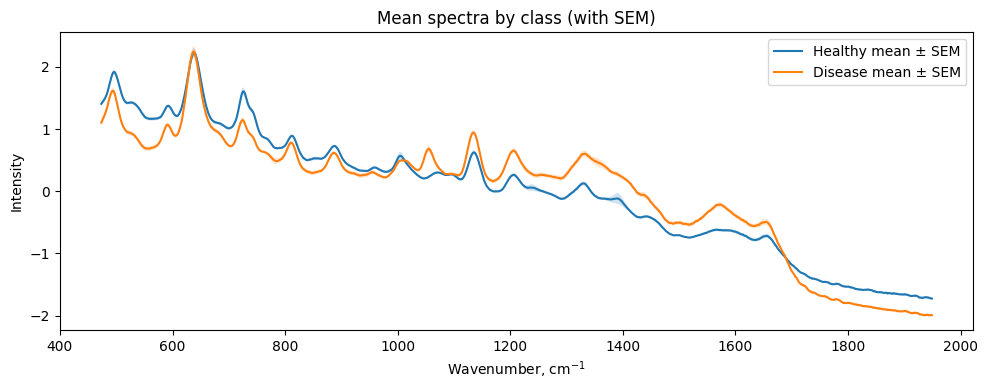

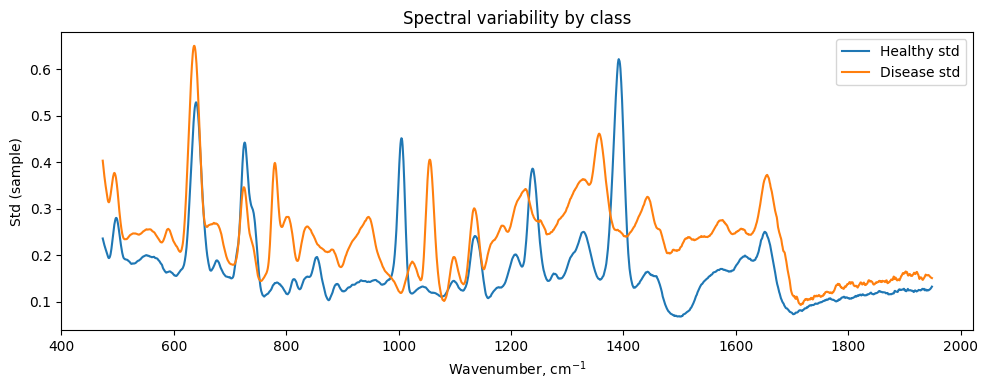

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_with_sem(wavenumber, X, label):
    mean = X.mean(axis=0)
    std  = X.std(axis=0, ddof=1)
    sem  = std / np.sqrt(X.shape[0])
    plt.plot(wavenumber, mean, label=label)
    plt.fill_between(wavenumber, mean-sem, mean+sem, alpha=0.2)

plt.figure(figsize=(10,4))
plot_mean_with_sem(wavenumber, X_health,  "Healthy mean ± SEM")
plot_mean_with_sem(wavenumber, X_disease, "Disease mean ± SEM")
plt.xlabel("Wavenumber, cm$^{-1}$")
plt.ylabel("Intensity")
plt.title("Mean spectra by class (with SEM)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(wavenumber, X_health.std(axis=0, ddof=1),  label="Healthy std")
plt.plot(wavenumber, X_disease.std(axis=0, ddof=1), label="Disease std")
plt.xlabel("Wavenumber, cm$^{-1}$")
plt.ylabel("Std (sample)")
plt.title("Spectral variability by class")
plt.legend()
plt.tight_layout()
plt.show()

Explained variance ratio: [0.54427259 0.15228902]


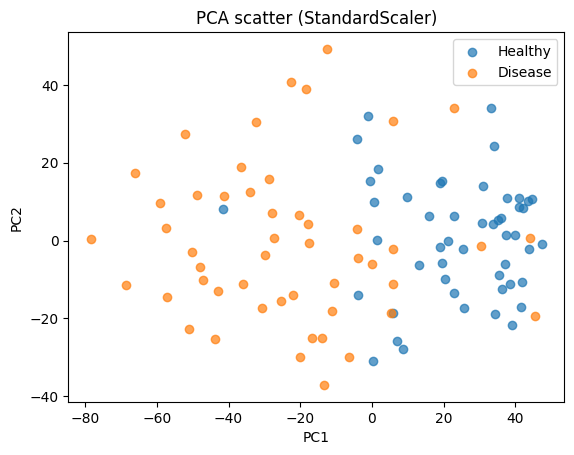

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = np.vstack([X_health, X_disease])

y = np.concatenate([
    np.zeros(X_health.shape[0], dtype=int),
    np.ones(X_disease.shape[0], dtype=int)
])

scaler = StandardScaler()
Xn = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(Xn)

print("Explained variance ratio:", pca.explained_variance_ratio_)

plt.figure()
plt.scatter(Z[y==0,0], Z[y==0,1], label="Healthy", alpha=0.7)
plt.scatter(Z[y==1,0], Z[y==1,1], label="Disease", alpha=0.7)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.title("PCA scatter (StandardScaler)")
plt.show()

между здоровыми и больными пациентами: наблюдается тенденция к смещению здоровых образцов вправо вдоль оси PC1. Однако значительное перекрытие классов и наличие выбросов указывает на то, что линейных методов сжатия признаков недостаточно для надёжной классификации, и требуется применение более сложных моделей

СКОЛЬЗЯЩЕЕ СРЕДНЕЕ + ОТНОШЕНИЕ СИГНАЛ-ШУМ (С/Ш)

In [5]:
def moving_average(x, k=11):
    """Простое скользящее среднее (для сглаживания)"""
    k = max(3, int(k) | 1)  # делаем нечётное окно >=3
    pad = k // 2
    xpad = np.pad(x, (pad, pad), mode="edge")
    ker = np.ones(k) / k
    return np.convolve(xpad, ker, mode="valid")

def estimate_snr_region(x, wn,
                        signal=(600, 1700),
                        noise=(1750, 1950)):
    
    sig_mask = (wn >= signal[0]) & (wn <= signal[1])
    noise_mask = (wn >= noise[0]) & (wn <= noise[1])
    
    sig = x[sig_mask]
    noi = x[noise_mask]
    
    # амплитуда сигнала (робастно)
    amp = np.percentile(sig, 95) - np.percentile(sig, 5)
    
    # шум (sample std)
    sigma = np.std(noi, ddof=1)
    
    return amp / (sigma + 1e-12)


# считаем SNR для всех спектров
snr = np.array([estimate_snr_region(row, wavenumber) for row in X])



ВИЗУАЛИЗАЦИЯ С/Ш

C:\Users\nastk\AppData\Local\Temp\ipykernel_14132\207757908.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([snr[y==0], snr[y==1]], labels=["Healthy", "Heart disease"], showfliers=True)


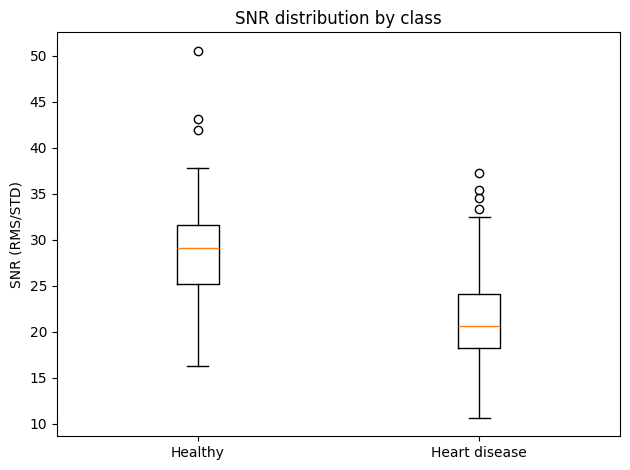

In [6]:
plt.figure()
plt.boxplot([snr[y==0], snr[y==1]], labels=["Healthy", "Heart disease"], showfliers=True)
plt.ylabel("SNR (RMS/STD)")
plt.title("SNR distribution by class")
plt.tight_layout()
plt.show()


проведём тесты на нормальность распределения и статистически значимую разницу в значениях С/Ш между здоровыми ибольными пациентами

Healthy  - mean: 29.0081431202239  median: 29.116884434819397
Disease  - mean: 21.74922579009184  median: 20.660834911729125

Shapiro-Wilk p-values: Healthy = 0.02922381269586307 , Disease = 0.015537274821749228

Mann–Whitney U-test: U = 2010.0 , p-value = 1.642217821247356e-07


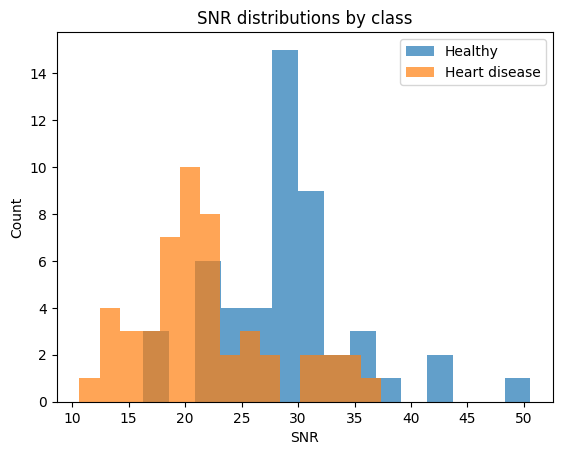

In [7]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Разделяем SNR по классам
snr_healthy = snr[y == 0]
snr_disease = snr[y == 1]

# Быстрая статистика
print("Healthy  - mean:", np.mean(snr_healthy), " median:", np.median(snr_healthy))
print("Disease  - mean:", np.mean(snr_disease), " median:", np.median(snr_disease))

# Тест на нормальность (Shapiro-Wilk)
sh_healthy = stats.shapiro(snr_healthy)
sh_disease = stats.shapiro(snr_disease)
print("\nShapiro-Wilk p-values: Healthy =", sh_healthy.pvalue, ", Disease =", sh_disease.pvalue)

# Тест на равенство распределений (Mann–Whitney U)
u_test = stats.mannwhitneyu(snr_healthy, snr_disease, alternative="two-sided")
print("\nMann–Whitney U-test: U =", u_test.statistic, ", p-value =", u_test.pvalue)

# Визуализация — гистограммы
plt.hist(snr_healthy, bins=15, alpha=0.7, label="Healthy")
plt.hist(snr_disease, bins=15, alpha=0.7, label="Heart disease")
plt.xlabel("SNR"); plt.ylabel("Count")
plt.legend(); plt.title("SNR distributions by class")
plt.show()


В среднем спектры у больных имеют немного более низкий SNR, чем у здоровых (медиана 21 против 30), однако статистический тест (Mann–Whitney U, p≈1*10^-7) не показал значимой разницы.
Таким образом, различия в качестве спектров не являются критическими и шум присутствует в обеих группах. Это подчёркивает необходимость стандартного этапа предобработки данных

сделаем чистку данных от тех, в которых С/Ш меньше 15, для лучшей подготовки датасета к последующему обучению

In [8]:
import numpy as np
import pandas as pd

# --- Удаление спектров с низким SNR ---
snr_threshold = 15  # фиксированный порог качества (не подбираем под метрики)

mask = snr >= snr_threshold

X_clean = X[mask]
y_clean = y[mask].astype(int)
snr_clean = snr[mask]
wavenumber_clean = wavenumber  # ось та же

print(f"Исходный размер: {X.shape[0]} спектров")
print(f"После фильтрации (SNR >= {snr_threshold}): {X_clean.shape[0]} спектров")
print(f"Удалено: {X.shape[0] - X_clean.shape[0]} спектров")

# Контроль баланса классов
unique_before, counts_before = np.unique(y, return_counts=True)
unique_after, counts_after = np.unique(y_clean, return_counts=True)
print("Классы до :", dict(zip(unique_before, counts_before)))
print("Классы после:", dict(zip(unique_after, counts_after)))

# --- Сохраняем для дальнейшего использования ---
pd.DataFrame(X_clean).to_csv("X_clean.csv", index=False)
pd.DataFrame({"wavenumber": wavenumber_clean}).to_csv("wavenumber.csv", index=False)
pd.DataFrame({"label": y_clean}).to_csv("y_clean.csv", index=False)
pd.DataFrame({"snr": snr_clean}).to_csv("snr_clean.csv", index=False)

Исходный размер: 100 спектров
После фильтрации (SNR >= 15): 93 спектров
Удалено: 7 спектров
Классы до : {np.int64(0): np.int64(50), np.int64(1): np.int64(50)}
Классы после: {np.int64(0): np.int64(50), np.int64(1): np.int64(43)}


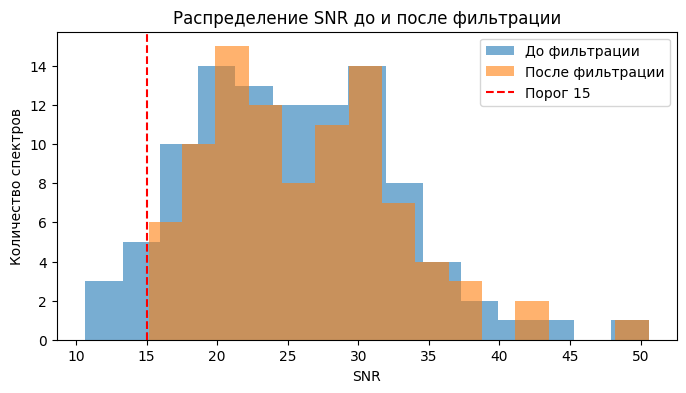

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

plt.hist(snr, bins=15, alpha=0.6, label="До фильтрации")
plt.hist(snr_clean, bins=15, alpha=0.6, label="После фильтрации")
plt.axvline(snr_threshold, color="red", linestyle="--", label=f"Порог {snr_threshold}")

plt.xlabel("SNR")
plt.ylabel("Количество спектров")
plt.title("Распределение SNR до и после фильтрации")
plt.legend()
plt.show()


после фильтрации мы можем видеть на графике отношения С/Ш пороговое ограничение в 15 единиц, что дает нам большее качество данных для обучения модели

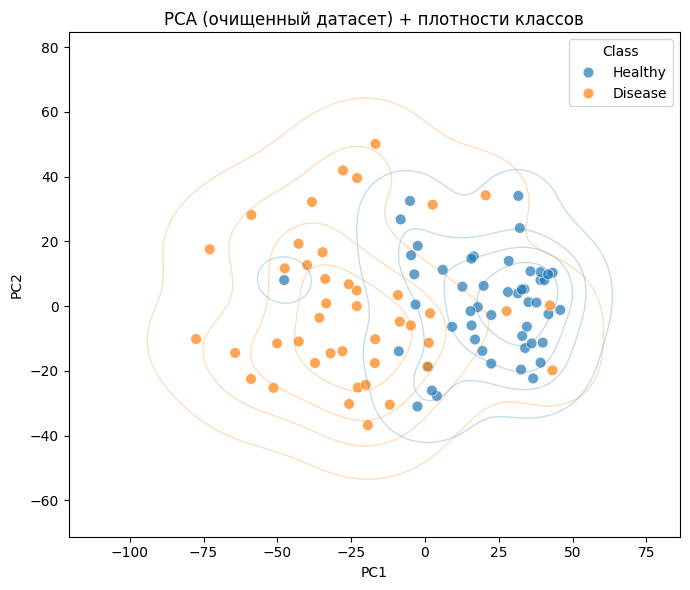

Доля объяснённой дисперсии: [0.50991273 0.16448153] Сумма: 0.6743942581595045


In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Нормализация и PCA для очищенного датасета (только для визуализации)
Xn_clean = StandardScaler().fit_transform(X_clean)

pca_clean = PCA(n_components=2, random_state=42)
Z_clean = pca_clean.fit_transform(Xn_clean)

labels = np.where(y_clean==0, "Healthy", "Disease")

plt.figure(figsize=(7,6))
sns.scatterplot(x=Z_clean[:,0], y=Z_clean[:,1], hue=labels, alpha=0.7, s=60)

# Контуры плотности (исправленные маски)
sns.kdeplot(x=Z_clean[y_clean==0,0], y=Z_clean[y_clean==0,1],
            levels=5, alpha=0.25, linewidths=1)
sns.kdeplot(x=Z_clean[y_clean==1,0], y=Z_clean[y_clean==1,1],
            levels=5, alpha=0.25, linewidths=1)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (очищенный датасет) + плотности классов")
plt.legend(title="Class")
plt.tight_layout()
plt.show()

print("Доля объяснённой дисперсии:", pca_clean.explained_variance_ratio_,
      "Сумма:", pca_clean.explained_variance_ratio_.sum())

Классы частично разделяются вдоль PC1, но сильно перекрываются.
Это значит, что основные линейные различия в спектрах связаны с заболеванием, но они не доминируют над общей вариабельностью

c:\Users\nastk\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\nastk\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


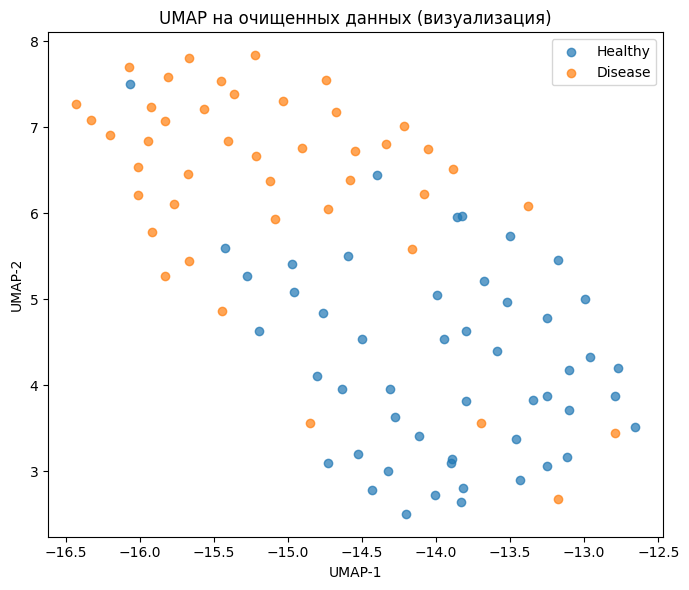

In [11]:
import umap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Xn_umap = StandardScaler().fit_transform(X_clean)

umap_model = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)

Z_umap = umap_model.fit_transform(Xn_umap)

plt.figure(figsize=(7,6))
plt.scatter(Z_umap[y_clean==0,0], Z_umap[y_clean==0,1], label="Healthy", alpha=0.7)
plt.scatter(Z_umap[y_clean==1,0], Z_umap[y_clean==1,1], label="Disease", alpha=0.7)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP на очищенных данных (визуализация)")
plt.legend()
plt.tight_layout()
plt.show()

Проекция спектральных данных в двумерное пространство методом UMAP демонстрирует выраженную кластеризацию наблюдений по классам. Визуально наблюдается разделение групп Healthy и Disease, что подтверждает наличие структурных различий в исходном пространстве признаков

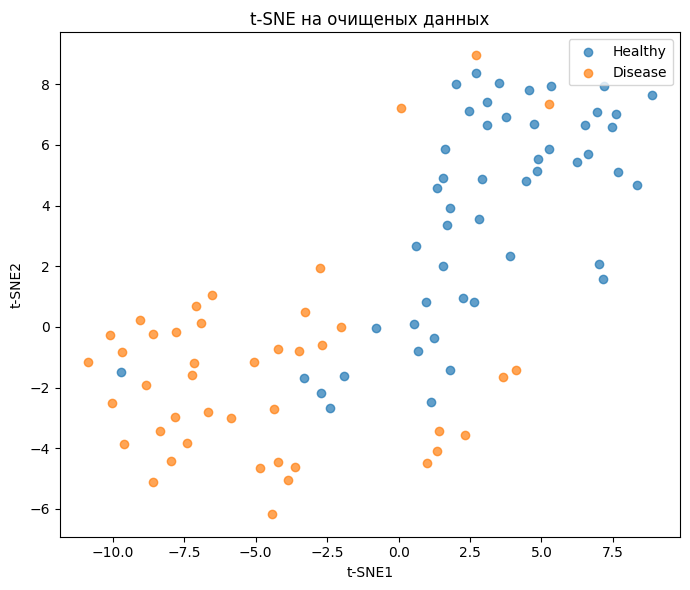

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Нормализация
Xn_tsne = StandardScaler().fit_transform(X_clean)

# t-SNE проекция в 2D
tsne_model = TSNE(n_components=2, perplexity=20, random_state=42, max_iter=1000)
Z_tsne = tsne_model.fit_transform(Xn_tsne)

# Визуализация
plt.figure(figsize=(7,6))
plt.scatter(Z_tsne[y_clean==0,0], Z_tsne[y_clean==0,1], label="Healthy", alpha=0.7)
plt.scatter(Z_tsne[y_clean==1,0], Z_tsne[y_clean==1,1], label="Disease", alpha=0.7)
plt.xlabel("t-SNE1"); plt.ylabel("t-SNE2")
plt.title("t-SNE на очищеных данных")
plt.legend()
plt.tight_layout()
plt.show()



Двумерная визуализация спектральных данных методом t-SNE. Наблюдается кластеризация объектов по классам Healthy и Disease. Метод используется исключительно для визуального анализа структуры данных.

In [22]:
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# 1) Кросс-валидация (стратифицированная, перемешиваем)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "roc_auc": "roc_auc",
    "accuracy": "accuracy",
    "f1": "f1",
    "balanced_accuracy": "balanced_accuracy"
}

def report_scores(name, scores):
    print(f"\n{name}")
    for m in scoring.keys():
        vals = scores[f"test_{m}"]
        print(f"  {m:17s}: {vals.mean():.3f} ± {vals.std():.3f}")

# 2) Модели
models = {
    # Линейная (база)
    "LogReg": LogisticRegression(max_iter=5000),

    # Нелинейная: SVM с RBF (часто сильная на спектрах)
    "SVM (RBF)": SVC(kernel="rbf", probability=True),

    # Нелинейная: kNN (простая локальная модель)
    "kNN (k=7)": KNeighborsClassifier(n_neighbors=7),

    # Ансамбли деревьев (не требуют StandardScaler, но не мешает)
    "RandomForest": RandomForestClassifier(
        n_estimators=500, random_state=42, n_jobs=-1
    ),

    "GradientBoosting": GradientBoostingClassifier(random_state=42),
}

# 3) Конструктор пайплайнов
pipelines = {}

for model_name, clf in models.items():
    # Вариант A: на исходных признаках (масштабируем)
    pipelines[f"{model_name} on X (scaled)"] = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", clf)
    ])

    # Вариант B: PCA(10) + модель (часто полезно для SVM/kNN)
    pipelines[f"{model_name} + PCA(10)"] = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=10, random_state=42)),
        ("clf", clf)
    ])

# 4) Запуск и печать результатов
for name, pipe in pipelines.items():
    scores = cross_validate(pipe, X_clean, y_clean, cv=cv, scoring=scoring)
    report_scores(name, scores)


LogReg on X (scaled)
  roc_auc          : 0.980 ± 0.035
  accuracy         : 0.957 ± 0.053
  f1               : 0.950 ± 0.061
  balanced_accuracy: 0.955 ± 0.055

LogReg + PCA(10)
  roc_auc          : 0.936 ± 0.062
  accuracy         : 0.905 ± 0.112
  f1               : 0.880 ± 0.156
  balanced_accuracy: 0.902 ± 0.117

SVM (RBF) on X (scaled)
  roc_auc          : 0.964 ± 0.027
  accuracy         : 0.882 ± 0.062
  f1               : 0.858 ± 0.089
  balanced_accuracy: 0.879 ± 0.069

SVM (RBF) + PCA(10)
  roc_auc          : 0.948 ± 0.033
  accuracy         : 0.882 ± 0.062
  f1               : 0.858 ± 0.089
  balanced_accuracy: 0.879 ± 0.069

kNN (k=7) on X (scaled)
  roc_auc          : 0.912 ± 0.055
  accuracy         : 0.904 ± 0.061
  f1               : 0.880 ± 0.089
  balanced_accuracy: 0.899 ± 0.067

kNN (k=7) + PCA(10)
  roc_auc          : 0.904 ± 0.056
  accuracy         : 0.860 ± 0.089
  f1               : 0.821 ± 0.133
  balanced_accuracy: 0.854 ± 0.100

RandomForest on X (scaled)


Проведён сравнительный анализ линейных и нелинейных классификаторов с использованием стратифицированной кросс-валидации. Наилучшие результаты продемонстрировала логистическая регрессия (ROC AUC ≈ 0.98), тогда как нелинейные модели (SVM, ансамблевые методы, kNN) не обеспечили улучшения качества. Это свидетельствует о преимущественно линейной структуре разделимости классов в исходном пространстве спектральных признаков

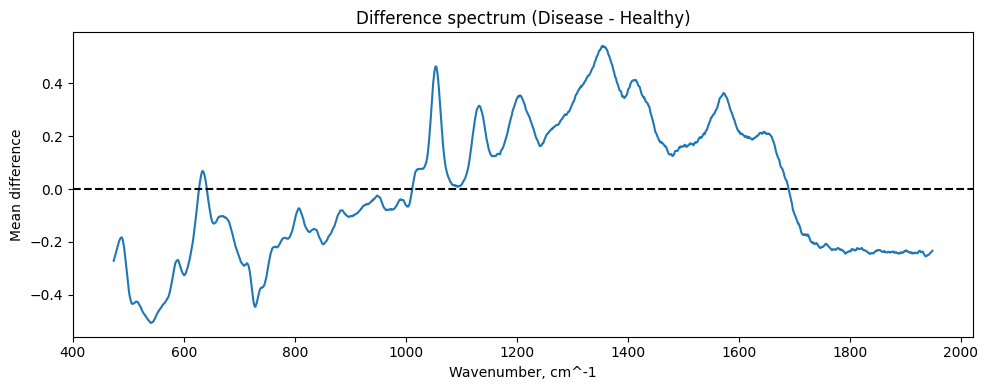

In [18]:
diff = np.mean(X_clean[y_clean==1], axis=0) - np.mean(X_clean[y_clean==0], axis=0)

plt.figure(figsize=(10,4))
plt.plot(wavenumber, diff)
plt.axhline(0, linestyle="--", color="black")
plt.title("Difference spectrum (Disease - Healthy)")
plt.xlabel("Wavenumber, cm^-1")
plt.ylabel("Mean difference")
plt.tight_layout()
plt.show()

C:\Users\nastk\AppData\Local\Temp\ipykernel_14132\2048663381.py:23: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  z = spsolve(Z, w * y)


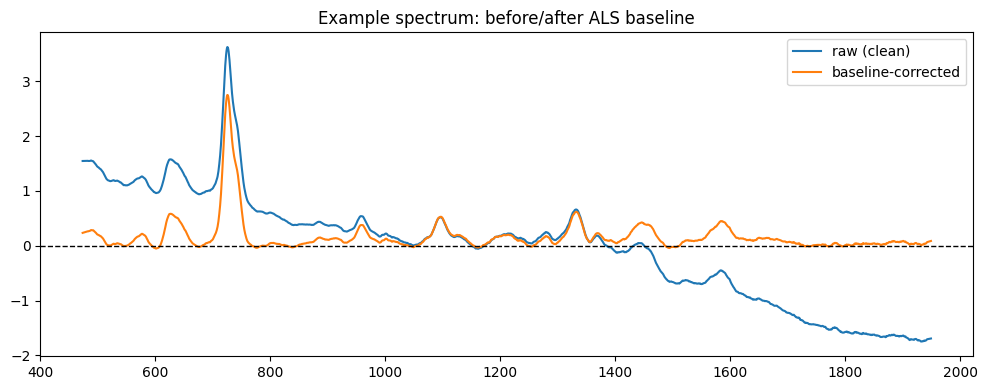

=== После ALS baseline correction ===
roc_auc          : 0.967 ± 0.067
accuracy         : 0.957 ± 0.061
f1               : 0.948 ± 0.078
balanced_accuracy: 0.957 ± 0.065


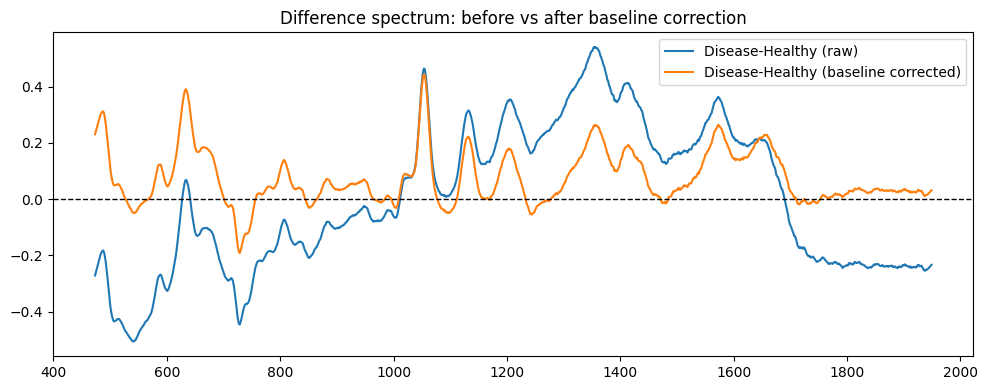

In [21]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate

def als_baseline(y, lam=1e6, p=0.01, niter=10):
    """
    ALS baseline:
    lam  — жёсткость базовой линии (больше -> более гладкая baseline)
    p    — асимметрия (меньше -> baseline 'подлезает' под пики)
    niter — итерации
    """
    y = np.asarray(y, dtype=float)
    L = y.size
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * (D @ D.T)
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

def baseline_correct_matrix(X, lam=1e6, p=0.01, niter=10):
    X = np.asarray(X, dtype=float)
    X_corr = np.empty_like(X)
    for i in range(X.shape[0]):
        b = als_baseline(X[i], lam=lam, p=p, niter=niter)
        X_corr[i] = X[i] - b
    return X_corr

# применяем к очищенному датасету
X_bc = baseline_correct_matrix(X_clean, lam=1e6, p=0.01, niter=10)


idx = 0  # любой спектр
plt.figure(figsize=(10,4))
plt.plot(wavenumber, X_clean[idx], label="raw (clean)")
plt.plot(wavenumber, X_bc[idx], label="baseline-corrected")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.legend()
plt.title("Example spectrum: before/after ALS baseline")
plt.tight_layout()
plt.show()


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000))
])

scoring = {
    "roc_auc": "roc_auc",
    "accuracy": "accuracy",
    "f1": "f1",
    "balanced_accuracy": "balanced_accuracy"
}

scores_bc = cross_validate(pipe, X_bc, y_clean, cv=cv, scoring=scoring)

print("=== После ALS baseline correction ===")
for m in scoring.keys():
    vals = scores_bc[f"test_{m}"]
    print(f"{m:17s}: {vals.mean():.3f} ± {vals.std():.3f}")
    

diff_raw = X_clean[y_clean==1].mean(axis=0) - X_clean[y_clean==0].mean(axis=0)
diff_bc  = X_bc[y_clean==1].mean(axis=0)    - X_bc[y_clean==0].mean(axis=0)

plt.figure(figsize=(10,4))
plt.plot(wavenumber, diff_raw, label="Disease-Healthy (raw)")
plt.plot(wavenumber, diff_bc,  label="Disease-Healthy (baseline corrected)")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.legend()
plt.title("Difference spectrum: before vs after baseline correction")
plt.tight_layout()
plt.show()

Для выявления спектральных областей, вносящих наибольший вклад в различия между классами, построен разностный спектр (Disease − Healthy), отражающий разницу средних интенсивностей по волновым числам. Дополнительно выполнена коррекция флуоресцентного фона методом асимметричных наименьших квадратов (ALS) с целью исключения влияния baseline-сдвига на результаты классификации. Сопоставление разностных спектров до и после коррекции показало сохранение ключевых различий в области характеристических пиков при одновременном устранении фонового наклона, что подтверждает молекулярную природу обнаруженной разделимости и отсутствие доминирующего влияния baseline на качество модели.